In [4]:
import requests as q
import json
import numpy as np

In [133]:
API_KEY = "D6427ILDPCC3RZCA"

def _api_call(symbol, candle="5min", output_size="compact"):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock}&interval={skip}&apikey={key}&outputsize={output_size}".format(
        stock=symbol, skip=candle, key=API_KEY, output_size=output_size
    )
    print("API::%s" % url)
    s = q.get(url)
    return s.json()

In [134]:
# test
d = _api_call('AMZN', candle="5min", output_size="full")
print(d['Meta Data'])

API::https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=AMZN&interval=5min&apikey=D6427ILDPCC3RZCA&outputsize=full
{'1. Information': 'Intraday (5min) prices and volumes', '2. Symbol': 'AMZN', '3. Last Refreshed': '2018-02-05 15:10:00', '4. Interval': '5min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}


In [135]:
# get time series
ts = d['Time Series (5min)']
len(ts)

780

In [136]:
def prep_data(ts):
    ts = list(ts.items())
    data = []
    for _, v in ts:
        v = v.items()
        data.append({key[3:]: float(val) for key, val in v})
    return data
            
data = prep_data(ts)
data[0]

{'close': 1391.56,
 'high': 1408.82,
 'low': 1388.0,
 'open': 1404.9601,
 'volume': 145334.0}

In [137]:
def calc_pivots(p):
    pp = (p['high'] + p['low'] + p['close']) / 3
    r1 = pp * 2 - p['low']
    s1 = pp * 2 - p['high']
    r2 = pp + (p['high'] - p['low'])
    s2 = pp - (p['high'] - p['low'])
    r3 = p['high'] + 2 * (pp - p['low'])
    s3 = p['low'] - 2 * (p['high'] - pp)
    return s3, s2, s1, pp, r1, r2, r3

calc_pivots(data[1])

(1383.0, 1393.0, 1398.0, 1408.0, 1413.0, 1423.0, 1428.0)

In [138]:
import matplotlib.pyplot as plt

In [139]:
X = list(range(1, len(data)))
pivots = []
Y = []
for ix in range(1, len(data)):
    pivots.append(calc_pivots(data[ix-1]))
    Y.append(data[ix]['close'])
s3, s2, s1, pp, r1, r2, r3 = list(np.array(pivots).T)
len(Y)

779

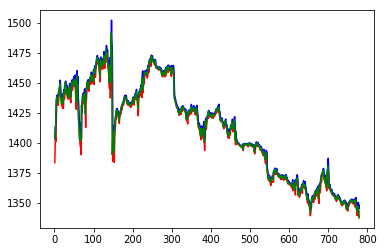

In [140]:
plt.plot(X, s1, 'r', X, r1, 'b', X, Y, 'g')
plt.show()

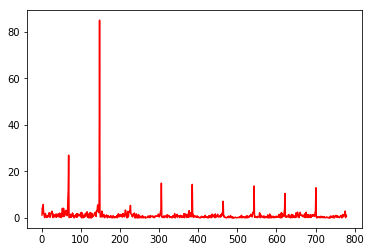

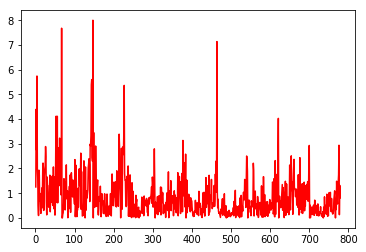

In [145]:
err = [min(abs(y - r1[i]), abs(y - s1[i])) for i, y in enumerate(Y)]

plt.plot(X, err, 'r')
plt.show()

low_err = [e if e < 10 else 0 for e in err]
plt.plot(X, low_err, 'r')
plt.show()

In [99]:
# LETS MAKE A FUCKING LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Activation, Dense, LeakyReLU

In [162]:
model = Sequential()
# our input will be the pivot points from the previous candle (7), and formatted to include a timestep
model.add(LSTM(1, input_shape=(1, 7), return_sequences=False))
model.add(LeakyReLU(alpha=0.01))
# model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam')

In [163]:
X = np.asarray(pivots)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
print(scaler.data_max_)
X_train = scaler.transform(X)
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print(X_train.shape)
print(X_train[0])

[1471.66666667 1473.72933333 1476.20666667 1487.10333333 1502.20666667
 1513.10333333 1528.20666667]
(779, 7)
(779, 1, 7)
[[0.23831253 0.30103826 0.32798918 0.37580332 0.37807407 0.41986928
  0.42628207]]


In [169]:
Y = np.asarray(Y)
print(Y[0])
print(Y.shape)
Y_r = Y - r1
Y_s = Y - s1
print(Y_r.shape)
print(Y_s.shape)
Y_train = np.asarray((Y_r, Y_s)).T
Y_train.shape

1403.0
(779,)
(779,)
(779,)


(779, 2)

In [172]:
model.fit(X_train, Y_train, epochs=1000, batch_size=16, shuffle=True, validation_split=0.1)

Train on 701 samples, validate on 78 samples
Epoch 1/1000
701/701 [==============================] - 0s 197us/step - loss: 27.0955 - val_loss: 3.0871
Epoch 2/1000
701/701 [==============================] - 0s 166us/step - loss: 27.0769 - val_loss: 3.0868
Epoch 3/1000
701/701 [==============================] - 0s 152us/step - loss: 27.0742 - val_loss: 3.0866
Epoch 4/1000
701/701 [==============================] - 0s 146us/step - loss: 27.1007 - val_loss: 3.0862
Epoch 5/1000
701/701 [==============================] - 0s 145us/step - loss: 27.0818 - val_loss: 3.0859
Epoch 6/1000
701/701 [==============================] - 0s 145us/step - loss: 27.0809 - val_loss: 3.0857
Epoch 7/1000
701/701 [==============================] - 0s 150us/step - loss: 27.0859 - val_loss: 3.0853
Epoch 8/1000
701/701 [==============================] - 0s 146us/step - loss: 27.0780 - val_loss: 3.0850
Epoch 9/1000
701/701 [==============================] - 0s 147us/step - loss: 27.0890 - val_loss: 3.0847
Epoch 10/1

Epoch 78/1000
701/701 [==============================] - 0s 151us/step - loss: 27.0408 - val_loss: 3.0739
Epoch 79/1000
701/701 [==============================] - 0s 145us/step - loss: 27.0395 - val_loss: 3.0738
Epoch 80/1000
701/701 [==============================] - 0s 142us/step - loss: 27.0342 - val_loss: 3.0738
Epoch 81/1000
701/701 [==============================] - 0s 149us/step - loss: 27.0337 - val_loss: 3.0737
Epoch 82/1000
701/701 [==============================] - 0s 144us/step - loss: 27.0363 - val_loss: 3.0736
Epoch 83/1000
701/701 [==============================] - 0s 171us/step - loss: 27.0387 - val_loss: 3.0736
Epoch 84/1000
701/701 [==============================] - 0s 174us/step - loss: 27.0354 - val_loss: 3.0735
Epoch 85/1000
701/701 [==============================] - 0s 174us/step - loss: 27.0306 - val_loss: 3.0735
Epoch 86/1000
701/701 [==============================] - 0s 180us/step - loss: 27.0322 - val_loss: 3.0734
Epoch 87/1000
701/701 [=======================

Epoch 155/1000
701/701 [==============================] - 0s 160us/step - loss: 27.0180 - val_loss: 3.0715
Epoch 156/1000
701/701 [==============================] - 0s 150us/step - loss: 27.0188 - val_loss: 3.0715
Epoch 157/1000
701/701 [==============================] - 0s 147us/step - loss: 27.0198 - val_loss: 3.0715
Epoch 158/1000
701/701 [==============================] - 0s 146us/step - loss: 27.0182 - val_loss: 3.0715
Epoch 159/1000
701/701 [==============================] - 0s 156us/step - loss: 27.0181 - val_loss: 3.0715
Epoch 160/1000
701/701 [==============================] - 0s 142us/step - loss: 27.0165 - val_loss: 3.0715
Epoch 161/1000
701/701 [==============================] - 0s 143us/step - loss: 27.0191 - val_loss: 3.0714
Epoch 162/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0196 - val_loss: 3.0714
Epoch 163/1000
701/701 [==============================] - 0s 147us/step - loss: 27.0179 - val_loss: 3.0714
Epoch 164/1000
701/701 [=============

701/701 [==============================] - 0s 149us/step - loss: 27.0141 - val_loss: 3.0711
Epoch 232/1000
701/701 [==============================] - 0s 142us/step - loss: 27.0142 - val_loss: 3.0711
Epoch 233/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0141 - val_loss: 3.0711
Epoch 234/1000
701/701 [==============================] - 0s 145us/step - loss: 27.0138 - val_loss: 3.0711
Epoch 235/1000
701/701 [==============================] - 0s 158us/step - loss: 27.0140 - val_loss: 3.0711
Epoch 236/1000
701/701 [==============================] - 0s 154us/step - loss: 27.0139 - val_loss: 3.0711
Epoch 237/1000
701/701 [==============================] - 0s 152us/step - loss: 27.0143 - val_loss: 3.0711
Epoch 238/1000
701/701 [==============================] - 0s 155us/step - loss: 27.0138 - val_loss: 3.0711
Epoch 239/1000
701/701 [==============================] - 0s 155us/step - loss: 27.0141 - val_loss: 3.0711
Epoch 240/1000
701/701 [============================

701/701 [==============================] - 0s 150us/step - loss: 27.0128 - val_loss: 3.0711
Epoch 308/1000
701/701 [==============================] - 0s 154us/step - loss: 27.0127 - val_loss: 3.0711
Epoch 309/1000
701/701 [==============================] - 0s 147us/step - loss: 27.0128 - val_loss: 3.0711
Epoch 310/1000
701/701 [==============================] - 0s 150us/step - loss: 27.0126 - val_loss: 3.0710
Epoch 311/1000
701/701 [==============================] - 0s 151us/step - loss: 27.0125 - val_loss: 3.0710
Epoch 312/1000
701/701 [==============================] - 0s 154us/step - loss: 27.0127 - val_loss: 3.0710
Epoch 313/1000
701/701 [==============================] - 0s 153us/step - loss: 27.0127 - val_loss: 3.0710
Epoch 314/1000
701/701 [==============================] - 0s 149us/step - loss: 27.0126 - val_loss: 3.0710
Epoch 315/1000
701/701 [==============================] - 0s 152us/step - loss: 27.0126 - val_loss: 3.0710
Epoch 316/1000
701/701 [============================

701/701 [==============================] - 0s 152us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 384/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 385/1000
701/701 [==============================] - 0s 145us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 386/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 387/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 388/1000
701/701 [==============================] - 0s 144us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 389/1000
701/701 [==============================] - 0s 140us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 390/1000
701/701 [==============================] - 0s 139us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 391/1000
701/701 [==============================] - 0s 151us/step - loss: 27.0123 - val_loss: 3.0710
Epoch 392/1000
701/701 [============================

701/701 [==============================] - 0s 162us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 460/1000
701/701 [==============================] - 0s 155us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 461/1000
701/701 [==============================] - 0s 147us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 462/1000
701/701 [==============================] - 0s 147us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 463/1000
701/701 [==============================] - 0s 149us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 464/1000
701/701 [==============================] - 0s 144us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 465/1000
701/701 [==============================] - 0s 145us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 466/1000
701/701 [==============================] - 0s 142us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 467/1000
701/701 [==============================] - 0s 152us/step - loss: 27.0122 - val_loss: 3.0710
Epoch 468/1000
701/701 [============================

701/701 [==============================] - 0s 156us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 536/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 537/1000
701/701 [==============================] - 0s 152us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 538/1000
701/701 [==============================] - 0s 149us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 539/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 540/1000
701/701 [==============================] - 0s 151us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 541/1000
701/701 [==============================] - 0s 154us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 542/1000
701/701 [==============================] - 0s 156us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 543/1000
701/701 [==============================] - 0s 151us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 544/1000
701/701 [============================

701/701 [==============================] - 0s 176us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 612/1000
701/701 [==============================] - 0s 172us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 613/1000
701/701 [==============================] - 0s 171us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 614/1000
701/701 [==============================] - 0s 148us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 615/1000
701/701 [==============================] - 0s 153us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 616/1000
701/701 [==============================] - 0s 149us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 617/1000
701/701 [==============================] - 0s 152us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 618/1000
701/701 [==============================] - 0s 151us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 619/1000
701/701 [==============================] - 0s 150us/step - loss: 27.0121 - val_loss: 3.0710
Epoch 620/1000
701/701 [============================

KeyboardInterrupt: 

In [192]:
Yhat = model.predict(X_train)
print(Yhat.shape)

(779, 2)


In [207]:
buy = True
capital = 1000
usd = capital
stock = 0
profit = []
buy_thresh = 5
sell_thresh = 1
for i, x in enumerate(Y):
    buy_dist, sell_dist = Yhat[i]
    if abs(buy_dist) < buy_thresh and buy:
        stock = usd / x
        usd = 0
        buy = False
    elif abs(sell_dist) < sell_thresh and not buy:
        n_usd = stock * x
        if len(profit) > 0 and n_usd - capital < profit[-1]:
            continue
        usd = n_usd
        stock = 0
        buy = True
        profit.append(usd - capital)
        print("Profit: %f" % profit[-1])

Profit: 3.991803
Profit: 17.063647
Profit: 18.167902
Profit: 21.603943
Profit: 23.192532
Profit: 23.693789
Profit: 24.118147
Profit: 24.520673
Profit: 26.968093
Profit: 28.275811
Profit: 31.590818
Profit: 32.767557
Profit: 36.728821
Profit: 38.633822
Profit: 40.830407
Profit: 41.935016
Profit: 44.979475
Profit: 45.036878
Profit: 50.653575
Profit: 51.581314
Profit: 53.672973
Profit: 54.371721
Profit: 54.651738
Profit: 54.677251
Profit: 55.385567
Profit: 57.407027
Profit: 60.450760
Profit: 62.895275
Profit: 72.360430


In [194]:
print("Final profit: $%.02f" % profit[-1])

Final profit: $72.36


In [188]:
model.save('AMZN.hd5')

In [190]:
from keras.models import load_model

In [191]:
model = load_model('AMZN-1.hd5')